## Lab 10 - Clasificación de Perros y Gatos

Stefano Aragoni, Carol Arévalo, Luis Diego Santos

### Importar Librerías


In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
import cv2
import random
import tensorflow as tf
from PIL import Image
from skimage import color, filters, measure

2023-05-04 15:42:17.151038: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


## 1.1 Lectura del Dataset

### Lectura y Procesamiento de Imagenes

In [2]:
def is_image_corrupted(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()
        return False
    except:
        return True

def contrast_stretching(image):
    # Compute the minimum and maximum intensity values of the image.
    min_val = np.min(image)
    max_val = np.max(image)
    
    # Define the new intensity range for the image.
    new_min = 0
    new_max = 255
    
    # Compute the scaling factor.
    scale = (new_max - new_min) / (max_val - min_val)
    
    # Apply the scaling factor to each pixel of the image.
    stretched_image = (image - min_val) * scale + new_min
    
    # Convert the image to 8-bit unsigned integer format.
    stretched_image = np.clip(stretched_image, 0, 255).astype(np.uint8)
    
    return stretched_image


In [3]:
def load_images(path, size=(100, 100)):
    images = []
    labels = []

    dirs = ["Cat", "Dog"]

    for dir in dirs:
        elements = os.listdir(path+'/'+dir)
        random.shuffle(elements)

        contador = 0

        for file in elements:
            if file.endswith('.jpg'):
                img_path = os.path.join(path+'/'+dir, file)
                label = 1 if 'Dog' == dir else 0

                corrupta = is_image_corrupted(img_path)

                if corrupta:
                    continue

                # Leer imagen a color
                img = cv2.imread(img_path)

                try:
                    img = contrast_stretching(img)

                    # Aplicar filtro bilateral con un diámetro de pixel de 9 y un rango de color de 75
                    img = cv2.bilateralFilter(img, 9, 75, 75)
                    
                    # Convertir imagen a escala de grises
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                    # Normalizar valores de píxeles
                    img = img / 255.0

                    img = contrast_stretching(img)

                    # expand the image to 100x100
                    img = cv2.resize(img, size)

                    # Girar imagen aleatoriamente
                    if random.random() < 0.5:
                        opt = random.randint(0, 3)

                        if opt == 1:
                            img = cv2.rotate(img, cv2.ROTATE_180)

                        elif opt == 2:
                            img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

                        elif opt == 3:
                            img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

                     # Cropear imagen aleatoriamente
                    if random.random() < 0.5:
                        h, w = img.shape
                        crop_size = random.randint(70, 90)
                        top = random.randint(0, h - crop_size)
                        left = random.randint(0, w - crop_size)
                        img = img[top:top+crop_size, left:left+crop_size]
                        img = cv2.resize(img, size)

                    # Flippea imagen aleatoriamente
                    if random.random() < 0.5:
                        img = cv2.flip(img, 1)

                    # Zommea imagen aleatoriamente
                    if random.random() < 0.5:
                        # Aplicar umbral adaptativo para binarizar imagen
                        binary_img = img > filters.threshold_local(img, block_size=40)

                        # Label the objects in the binary image
                        labeled_img = measure.label(binary_img)

                        # Find the properties of the labeled objects
                        properties = measure.regionprops(labeled_img)

                        # Find the object with the largest area
                        max_area = 0
                        max_area_index = 0
                        for i, prop in enumerate(properties):
                            if prop.area > max_area:
                                max_area = prop.area
                                max_area_index = i

                        # Extract the coordinates of the bounding box of the object
                        min_row, min_col, max_row, max_col = properties[max_area_index].bbox

                        # Crop the image to the bounding box of the object
                        img = img[min_row:max_row, min_col:max_col]

                    # expand the image to 100x100
                    img = cv2.resize(img, size)

                    # # show image on popup
                    # cv2.imshow('image', img)
                    # cv2.waitKey(0)
                    # cv2.destroyAllWindows()

                    images.append(img)
                    labels.append(label)
                            
                    if contador == 5000:
                        break

                    if contador % 100 == 0:
                        print("Imagenes procesadas: ", contador)  

                    contador += 1

                except Exception as e:
                    pass

    return np.array(images), np.array(labels)

### Importar Imagenes y Split de Dataset

In [4]:
# Definir ruta del conjunto de datos
data_path = './PetImages'

# Cargar imágenes y etiquetas
images, labels = load_images(data_path)

# Comprobar tamaños de los conjuntos
print('\nNúmero de imágenes por clase:', np.bincount(labels))

Imagenes procesadas:  0
Imagenes procesadas:  100
Imagenes procesadas:  200
Imagenes procesadas:  300
Imagenes procesadas:  400
Imagenes procesadas:  500
Imagenes procesadas:  600
Imagenes procesadas:  700
Imagenes procesadas:  800
Imagenes procesadas:  900
Imagenes procesadas:  1000
Imagenes procesadas:  1100
Imagenes procesadas:  1200
Imagenes procesadas:  1300
Imagenes procesadas:  1400
Imagenes procesadas:  1500
Imagenes procesadas:  1600
Imagenes procesadas:  1700
Imagenes procesadas:  1800


Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


Imagenes procesadas:  1900
Imagenes procesadas:  2000
Imagenes procesadas:  2100
Imagenes procesadas:  2200
Imagenes procesadas:  2300
Imagenes procesadas:  2400
Imagenes procesadas:  0
Imagenes procesadas:  100
Imagenes procesadas:  200


Corrupt JPEG data: 254 extraneous bytes before marker 0xd9


Imagenes procesadas:  300


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Imagenes procesadas:  400
Imagenes procesadas:  500
Imagenes procesadas:  600


Corrupt JPEG data: 2230 extraneous bytes before marker 0xd9


Imagenes procesadas:  700
Imagenes procesadas:  800


Corrupt JPEG data: 226 extraneous bytes before marker 0xd9


Imagenes procesadas:  900
Imagenes procesadas:  1000


Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


Imagenes procesadas:  1100
Imagenes procesadas:  1200
Imagenes procesadas:  1300
Imagenes procesadas:  1400
Imagenes procesadas:  1500
Imagenes procesadas:  1600
Imagenes procesadas:  1700
Imagenes procesadas:  1800
Imagenes procesadas:  1900
Imagenes procesadas:  2000
Imagenes procesadas:  2100
Imagenes procesadas:  2200
Imagenes procesadas:  2300
Imagenes procesadas:  2400

Número de imágenes por clase: [2501 2501]


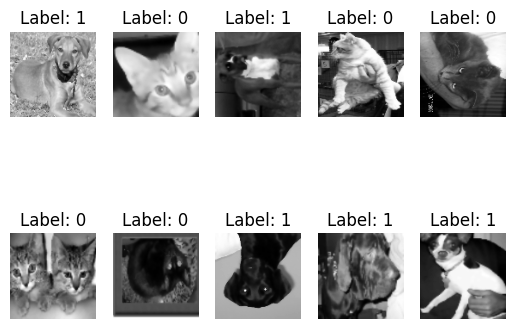

In [5]:
# Elegir 10 imágenes aleatorias para mostrar
random.seed(6)
random_idx = random.sample(range(0, len(images)), 10)
random_images = images[random_idx, :]
random_labels = labels[random_idx]

# Mostrar imágenes
for i in range(0, len(random_images)):
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.title('Label: ' + str(random_labels[i]))
    plt.imshow(random_images[i], cmap='gray')

In [6]:
# Dividir conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Dividir 20 de prueba en 10 de validación y 10 de prueba
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Verificar tamaños de los conjuntos
print('\nTamaño del conjunto de entrenamiento:', X_train.shape)
print('Tamaño del conjunto de validación:', X_val.shape)
print('Tamaño del conjunto de prueba:', X_test.shape)


Tamaño del conjunto de entrenamiento: (4001, 100, 100)
Tamaño del conjunto de validación: (501, 100, 100)
Tamaño del conjunto de prueba: (500, 100, 100)


In [7]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)
y_test = to_categorical(y_test, 2)

## 1.2 Construccion del Modelo

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
          epochs=32,
          verbose=0,
          steps_per_epoch=250,
          validation_data=(X_val, y_val))
 

Epoch 1/10
400/400 [==============================] - 70s 170ms/step - loss: 0.8589 - accuracy: 0.5620 - val_loss: 0.6889 - val_accuracy: 0.6048
Epoch 2/10
400/400 [==============================] - 60s 149ms/step - loss: 0.7129 - accuracy: 0.6257 - val_loss: 0.6211 - val_accuracy: 0.6766
Epoch 3/10
400/400 [==============================] - 66s 165ms/step - loss: 0.6386 - accuracy: 0.6582 - val_loss: 0.6515 - val_accuracy: 0.6307
Epoch 4/10
400/400 [==============================] - 64s 161ms/step - loss: 0.5831 - accuracy: 0.7032 - val_loss: 0.6443 - val_accuracy: 0.6507
Epoch 5/10
400/400 [==============================] - 55s 138ms/step - loss: 0.5450 - accuracy: 0.7373 - val_loss: 0.7640 - val_accuracy: 0.6347
Epoch 6/10
400/400 [==============================] - 58s 145ms/step - loss: 0.4965 - accuracy: 0.7576 - val_loss: 0.6190 - val_accuracy: 0.6707
Epoch 7/10
400/400 [==============================] - 55s 137ms/step - loss: 0.4690 - accuracy: 0.7798 - val_loss: 0.6457 - val_ac

In [10]:
test_loss, test_acc = model.evaluate(X_train, y_train, verbose=1)
print('\nAccuracy (Training):', test_acc)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print('\nAccuracy (Testing):', test_acc)

126/126 [==============================] - 10s 78ms/step - loss: 2.3415 - accuracy: 0.5109

Accuracy (Training): 0.5108723044395447
16/16 [==============================] - 1s 81ms/step - loss: 2.7980 - accuracy: 0.5140

Accuracy (Testing): 0.5139999985694885
